# CV Project: Deep Learning for Camera Pose Estimation: A Comparative Study on 7-Scenes

## 1. 环境与路径设置

In [ ]:
# demo.ipynb

import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt

from train import train
from eval import evaluate
from geometry_baseline import run_baseline

DATA_ROOT = "/Users/zhengbinheng/Desktop/7-scenes-dataset"  
OUT_DIR = "runs/posenet_chess"
CKPT_PATH = os.path.join(OUT_DIR, "best.ckpt")
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)


## 2. 训练 PoseNet (Chess)

In [2]:
args = argparse.Namespace(
    data_root=DATA_ROOT,
    scene="chess",
    epochs=30,
    batch_size=32,
    lr=1e-4,
    beta=120.0,
    out=OUT_DIR
)
train(args)  # best.ckpt + loss


/opt/anaconda3/envs/node2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[1/30] avg_loss = 28.3060
[2/30] avg_loss = 6.6044
[3/30] avg_loss = 5.2792
[4/30] avg_loss = 4.4213
[5/30] avg_loss = 3.5573
[6/30] avg_loss = 3.2622
[7/30] avg_loss = 2.9794
[8/30] avg_loss = 2.7576
[9/30] avg_loss = 2.5401
[10/30] avg_loss = 2.2813
[11/30] avg_loss = 2.3134
[12/30] avg_loss = 2.1574
[13/30] avg_loss = 2.0245
[14/30] avg_loss = 2.0114
[15/30] avg_loss = 1.9840
[16/30] avg_loss = 1.8095
[17/30] avg_loss = 1.7561
[18/30] avg_loss = 1.7470
[19/30] avg_loss = 1.6819
[20/30] avg_loss = 1.5306
[21/30] avg_loss = 1.7153
[22/30] avg_loss = 1.5844
[23/30] avg_loss = 1.6611
[24/30] avg_loss = 1.5131
[25/30] avg_loss = 1.4581
[26/30] avg_loss = 1.4694
[27/30] avg_loss = 1.4465
[28/30] avg_loss = 1.4176
[29/30] avg_loss = 1.4955
[30/30] avg_loss = 1.3441
Training finished. Best loss = 1.3441
Results saved in runs/posenet_chess


### 可视化训练曲线

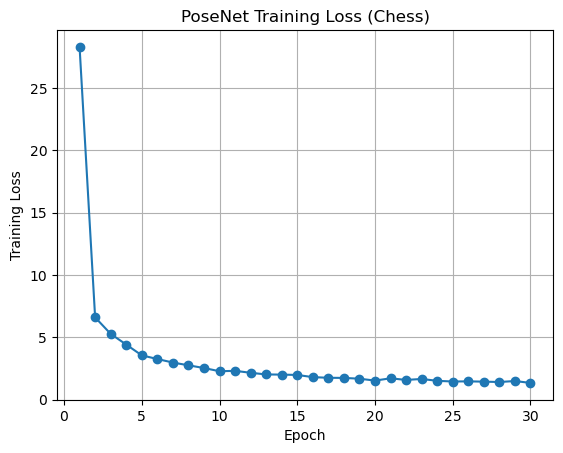

In [3]:
df_loss = pd.read_csv(os.path.join(OUT_DIR, "loss_curve.csv"))
plt.plot(df_loss["epoch"], df_loss["loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("PoseNet Training Loss (Chess)")
plt.grid(True)
plt.show()


## 3. PoseNet 测试与泛化 (fire + heads)

In [4]:
def run_eval(scene):
    args = argparse.Namespace(
        data_root=DATA_ROOT,
        scene=scene,
        ckpt=CKPT_PATH,
        out=os.path.join(RESULTS_DIR, f"{scene}_posenet.csv")
    )
    stats, df = evaluate(args)
    return stats, df

scenes = ["chess", "fire", "heads"]

pose_stats, pose_perframe = {}, {}
for s in scenes:
    stats, df = run_eval(s)
    pose_stats[s] = stats
    pose_perframe[s] = df


[PoseNet | chess] mean_t=0.198 m | median_t=0.151 m || mean_r=5.40° | median_r=4.55°
[PoseNet | fire] mean_t=0.933 m | median_t=0.920 m || mean_r=39.99° | median_r=35.66°
[PoseNet | heads] mean_t=0.807 m | median_t=0.769 m || mean_r=47.88° | median_r=46.98°


## 4. PnP+RANSAC 基线

In [9]:
import importlib
import geometry_baseline

importlib.reload(geometry_baseline)

from geometry_baseline import run_baseline

def run_baseline_eval(scene):
    args = argparse.Namespace(
        data_root=DATA_ROOT,
        scene=scene,
        orb_kpts=4000,
        topk=10,
        ratio=0.75,
        min_match=20,
        reproj=5.0,
        iters=2000,
        conf=0.999
    )
    stats, df = run_baseline(args)
    return stats, df

base_stats, base_perframe = {}, {}
for s in scenes:
    stats, df = run_baseline_eval(s)
    base_stats[s] = stats
    base_perframe[s] = df

[chess/seq-03] building per-sequence DB ...
[chess|seq-03] mean_t=0.006 m | median_t=0.005 m || mean_r=0.25° | median_r=0.18° | inliers~1544.0
[chess/seq-05] building per-sequence DB ...
[chess|seq-05] mean_t=0.004 m | median_t=0.003 m || mean_r=0.17° | median_r=0.11° | inliers~1761.5
[PnP+RANSAC | chess] mean_t=0.005 m | median_t=0.004 m || mean_r=0.21° | median_r=0.14°
[fire/seq-03] building per-sequence DB ...
[fire|seq-03] mean_t=0.005 m | median_t=0.004 m || mean_r=0.18° | median_r=0.15° | inliers~1733.8
[fire/seq-04] building per-sequence DB ...
[fire|seq-04] mean_t=0.005 m | median_t=0.004 m || mean_r=0.23° | median_r=0.16° | inliers~1520.6
[PnP+RANSAC | fire] mean_t=0.005 m | median_t=0.004 m || mean_r=0.21° | median_r=0.15°
[heads/seq-01] building per-sequence DB ...
[heads|seq-01] mean_t=0.004 m | median_t=0.003 m || mean_r=0.24° | median_r=0.17° | inliers~1107.2
[PnP+RANSAC | heads] mean_t=0.004 m | median_t=0.003 m || mean_r=0.24° | median_r=0.17°


## 5. 汇总对比表格

In [10]:
summary = pd.DataFrame([
    {
        "Scene": s,
        "PoseNet mean_t (m)": pose_stats[s]["mean_t"],
        "PoseNet median_t (m)": pose_stats[s]["median_t"],
        "PoseNet mean_r (°)": pose_stats[s]["mean_r"],
        "PoseNet median_r (°)": pose_stats[s]["median_r"],
        "PnP+RANSAC mean_t (m)": base_stats[s]["mean_t"],
        "PnP+RANSAC median_t (m)": base_stats[s]["median_t"],
        "PnP+RANSAC mean_r (°)": base_stats[s]["mean_r"],
        "PnP+RANSAC median_r (°)": base_stats[s]["median_r"],
    }
    for s in scenes
])

summary.round(3)


,Scene,PoseNet mean_t (m),PoseNet median_t (m),PoseNet mean_r (°),PoseNet median_r (°),PnP+RANSAC mean_t (m),PnP+RANSAC median_t (m),PnP+RANSAC mean_r (°),PnP+RANSAC median_r (°)
0,chess,0.198,0.151,5.404,4.545,0.005,0.004,0.211,0.143
1,fire,0.933,0.920,39.992,35.665,0.005,0.004,0.206,0.153
2,heads,0.807,0.769,47.878,46.977,0.004,0.003,0.243,0.168


## 6. 误差分布可视化 (直方图)

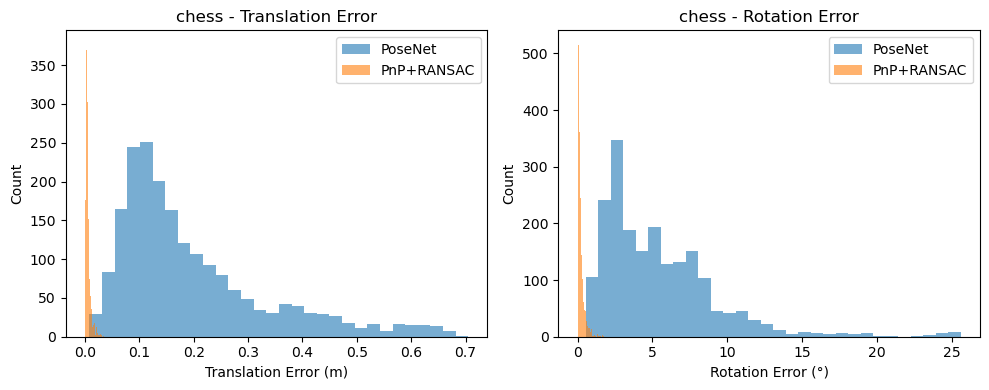

In [21]:
scene = "chess"
df_pose = pose_perframe[scene]
df_base = base_perframe[scene]

plt.figure(figsize=(10, 4))

# 平移误差
plt.subplot(1, 2, 1)
plt.hist(df_pose["t_err_m"], bins=30, alpha=0.6, label="PoseNet")
plt.hist(df_base["t_err_m"], bins=30, alpha=0.6, label="PnP+RANSAC")
plt.xlabel("Translation Error (m)")
plt.ylabel("Count")
plt.title(f"{scene} - Translation Error")
plt.legend()

# 旋转误差
plt.subplot(1, 2, 2)
plt.hist(df_pose["r_err_deg"], bins=30, alpha=0.6, label="PoseNet")
plt.hist(df_base["r_err_deg"], bins=30, alpha=0.6, label="PnP+RANSAC")
plt.xlabel("Rotation Error (°)")
plt.ylabel("Count")
plt.title(f"{scene} - Rotation Error")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# 导出 LaTeX 表格 (可选)

latex_table = summary.round(3).to_latex(index=False)
with open(os.path.join(RESULTS_DIR, "summary_table.tex"), "w") as f:
    f.write(latex_table)

print("LaTeX table saved to results/summary_table.tex")


LaTeX table saved to results/summary_table.tex


## 7. 轨迹可视化 (GT vs PoseNet vs PnP+RANSAC)

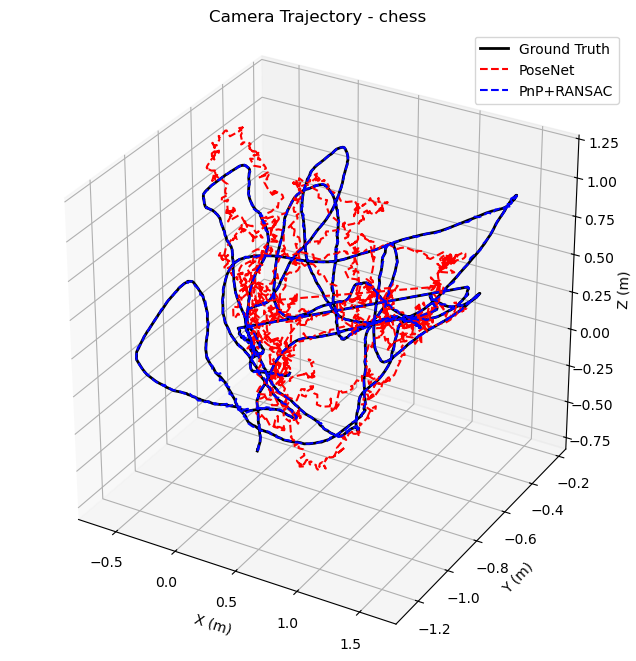

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

def plot_trajectory(scene):
    # read results
    df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
    df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Ground Truth
    ax.plot(df_pose["t_gt_x"], df_pose["t_gt_y"], df_pose["t_gt_z"],
            "k-", linewidth=2, label="Ground Truth")

    # PoseNet
    ax.plot(df_pose["t_pred_x"], df_pose["t_pred_y"], df_pose["t_pred_z"],
            "r--", linewidth=1.5, label="PoseNet")

    # Baseline
    ax.plot(df_base["t_pred_x"], df_base["t_pred_y"], df_base["t_pred_z"],
            "b--", linewidth=1.5, label="PnP+RANSAC")

    ax.set_title(f"Camera Trajectory - {scene}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_box_aspect([1,1,1])  # 保持比例一致
    ax.legend()
    plt.show()


# 示例：画 chess 场景
plot_trajectory("chess")

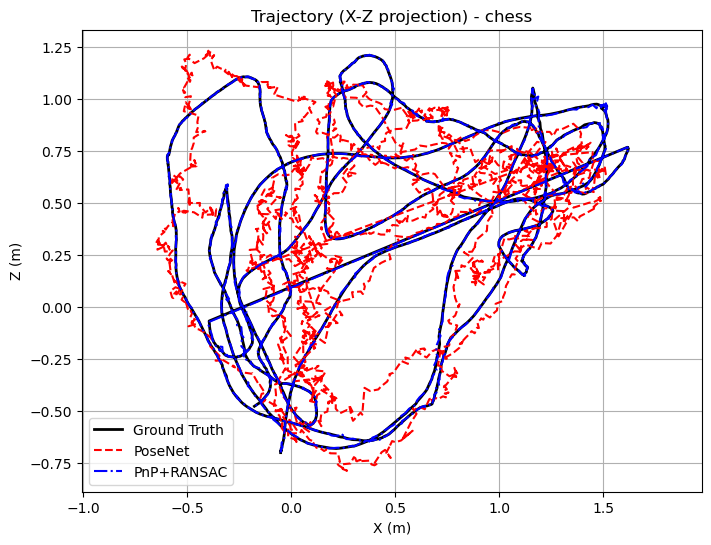

In [24]:
def plot_trajectory_2d(scene):
    df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
    df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

    plt.figure(figsize=(8,6))

    # Ground Truth
    plt.plot(df_pose["t_gt_x"], df_pose["t_gt_z"], "k-", linewidth=2, label="Ground Truth")

    # PoseNet
    plt.plot(df_pose["t_pred_x"], df_pose["t_pred_z"], "r--", linewidth=1.5, label="PoseNet")

    # Baseline
    plt.plot(df_base["t_pred_x"], df_base["t_pred_z"], "b-.", linewidth=1.5, label="PnP+RANSAC")

    plt.title(f"Trajectory (X-Z projection) - {scene}")
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.axis("equal")   # 保持比例一致
    plt.legend()
    plt.grid(True)
    plt.show()


# 示例：画 chess
plot_trajectory_2d("chess")